In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Alignment

In [2]:
# Function to apply scaling, translation, and rotation to the ground truth points
def transform_points(points, scale, translation, rotation_angle):
    # Apply scaling
    scaled_points = points * scale
    # Apply translation
    translated_points = scaled_points + translation
    # Apply rotation
    rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                [np.sin(rotation_angle), np.cos(rotation_angle)]])
    rotated_points = translated_points @ rotation_matrix.T
    return rotated_points

# Function to calculate the minimum distance from each estimated point to the nearest ground truth point
def calculate_minimum_distances(ground_truth_points, estimated_points):
    distances = []
    for est_point in estimated_points:
        # Calculate Euclidean distance between this estimated point and all ground truth points
        dist = np.linalg.norm(ground_truth_points - est_point, axis=1)
        # Find the minimum distance for this estimated point
        distances.append(np.min(dist))
    return np.array(distances)

# Objective function to minimize: sum of minimum distances from estimated points to transformed ground truth points
def objective_function(params, ground_truth_points, estimated_points):
    scale = params[0]  # Scaling factor
    translation = np.array([params[1], params[2]])  # Translation (Δx, Δy)
    rotation_angle = params[3]  # Rotation angle θ
    # Transform the ground truth points
    transformed_points = transform_points(ground_truth_points, scale, translation, rotation_angle)
    # Calculate the sum of minimum distances between transformed ground truth and estimated points
    min_distances = calculate_minimum_distances(transformed_points, estimated_points)
    return np.sum(min_distances**2)

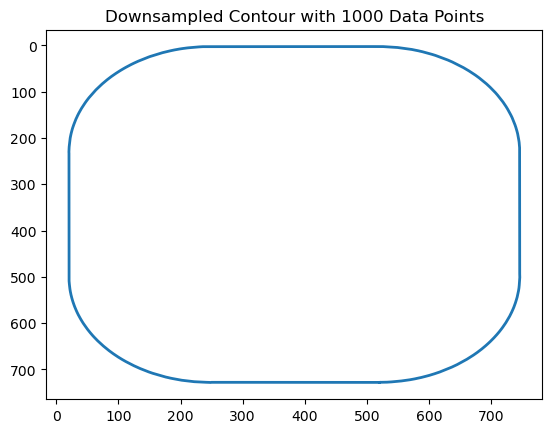

In [3]:
from skimage import io
from skimage.measure import find_contours

# Load the image
image_path = 'RectGTContour.png'
image = io.imread(image_path, as_gray=True)

# Find contours at a constant value of 0.5 (assuming the image is binary or grayscale)
contours = find_contours(image, level=0.5)

# For simplicity, we will assume the largest contour is the object contour
largest_contour = max(contours, key=len)

# Downsample the contour to 1000 data points
if len(largest_contour) > 5000:
    indices = np.linspace(0, len(largest_contour) - 1, 1000).astype(int)
    downsampled_contour = largest_contour[indices]
else:
    downsampled_contour = largest_contour

# Plot the result to ensure it's correct
plt.figure()
plt.plot(downsampled_contour[:, 1], downsampled_contour[:, 0], linewidth=2)
plt.gca().invert_yaxis()  # Invert y axis to match image coordinate system
plt.title('Downsampled Contour with 1000 Data Points')
plt.show()

In [4]:


# Convert ground truth points from millimeters (mm) to meters (m)
downsampled_contour /= 1000  # Divide by 1000 to convert mm to meters

# Load the estimated points from a .txt file
# Replace 'estimated_points.txt' with the actual path of your file
estimated_points_file = 'ForEvaluation.txt'
estimated_points_df = pd.read_csv(estimated_points_file, header=None)

# Ensure all values are numeric (convert any strings to NaN, then drop rows with NaN if needed)
estimated_points_df = estimated_points_df.apply(pd.to_numeric, errors='coerce')
estimated_points_df = estimated_points_df.dropna()  # Drop any rows with invalid data

# Convert DataFrame to numpy array after cleaning
estimated_points = estimated_points_df.values

# Initial guess for the optimization
initial_guess = [1, 0, 0, 0]  # Initial guess: scaling = 1, translation = (0,0), rotation = 0

# Perform optimization to align the ground truth points with the estimated points (including scaling)
result = minimize(objective_function, initial_guess, args=(downsampled_contour, estimated_points))

# Extract the optimal scaling, translation, and rotation
optimal_scale = result.x[0]
optimal_translation = [result.x[1], result.x[2]]
optimal_rotation = result.x[3]

# Apply the optimal transformation (scaling, translation, rotation) to the ground truth points
aligned_ground_truth_points = transform_points(downsampled_contour, optimal_scale, optimal_translation, optimal_rotation)

# Calculate minimum distances between the aligned ground truth points and the estimated points
minimum_distances = calculate_minimum_distances(aligned_ground_truth_points, estimated_points)

# Compute mean and standard deviation of the minimum distances
mean_distance = np.mean(minimum_distances)
std_distance = np.std(minimum_distances)


Mean Minimum Distance: 0.001930 meters
Standard Deviation of Minimum Distance: 0.001028 meters
Optimal Scaling Factor: 0.2899742954828556


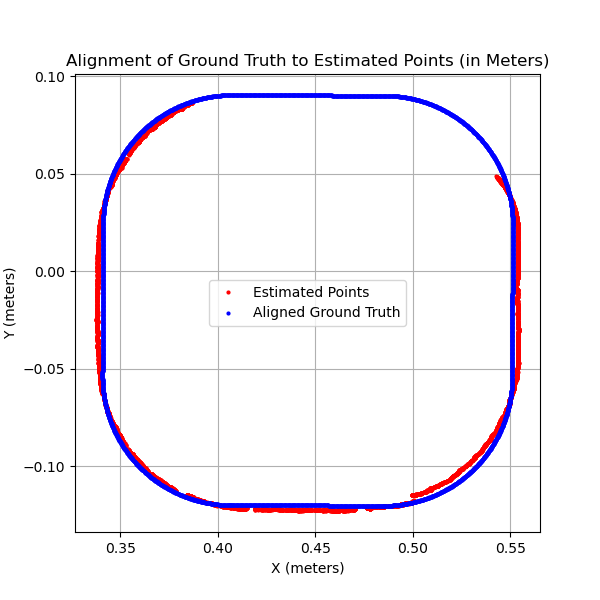

In [5]:
%matplotlib widget

# Output the results
print(f"Mean Minimum Distance: {mean_distance:.6f} meters")
print(f"Standard Deviation of Minimum Distance: {std_distance:.6f} meters")
print(f"Optimal Scaling Factor: {optimal_scale}")

# Plot the aligned ground truth points and the estimated points
plt.figure(figsize=(6, 6))
plt.plot(estimated_points[:, 0], estimated_points[:, 1], 'ro', label='Estimated Points', markersize=2)
plt.plot(aligned_ground_truth_points[:, 0], aligned_ground_truth_points[:, 1], 'bo', label='Aligned Ground Truth', markersize=2)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Alignment of Ground Truth to Estimated Points (in Meters)')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.grid(True)
plt.legend()
plt.show()